# UFC Betting

## Data Loading and Merging

In [1]:
from pathlib import Path

import pandas as pd

data_path = Path().cwd().parent / 'data' / 'external' / 'ufc-master.csv'

df = pd.read_csv(data_path)

In [2]:
pattern_dif = r'_dif$'
df_dif = df.filter(regex=pattern_dif)

pattern_b = r'^B_'
df_b = df.filter(regex=pattern_b)

pattern_r = r'^R_'
df_r = df.filter(regex=pattern_r)

In [3]:
other_cols = df_dif.columns.append(df_b.columns).append(df_r.columns)

df_info = df.drop(other_cols, axis=1)

df2 = pd.concat([df_info, df_dif], axis=1)

df3 = pd.concat([
    df2,
    df_b[['B_fighter', 'B_odds']],
    df_r[['R_fighter', 'R_odds']]
],
    axis=1)

df3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4588 entries, 0 to 4587
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    4588 non-null   object 
 1   location                4588 non-null   object 
 2   country                 4588 non-null   object 
 3   Winner                  4588 non-null   object 
 4   title_bout              4588 non-null   bool   
 5   weight_class            4588 non-null   object 
 6   gender                  4588 non-null   object 
 7   no_of_rounds            4588 non-null   int64  
 8   empty_arena             4588 non-null   int64  
 9   constant_1              4588 non-null   int64  
 10  better_rank             4588 non-null   object 
 11  finish                  4118 non-null   object 
 12  finish_details          2014 non-null   object 
 13  finish_round            4099 non-null   float64
 14  finish_round_time       4099 non-null   

In [4]:
ufc = df3.drop(['finish_details', 'constant_1'], axis=1)

ufc.dropna(inplace=True)

----

## EDA
### **Question:** Who will win the fight?

In [5]:
pd.set_option('display.max_columns', None) # set to view all columns
 
ufc.head()

,date,location,country,Winner,title_bout,weight_class,gender,no_of_rounds,empty_arena,better_rank,finish,finish_round,finish_round_time,total_fight_time_secs,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,B_fighter,B_odds,R_fighter,R_odds
233,8/29/2020,"Las Vegas, Nevada, USA",USA,Blue,False,Light Heavyweight,MALE,3,1,Red,U-DEC,3.0,5:00,900.0,0,0,1,-6,-6,-31,-1,-4,-3,0.00,5.08,-4,1.98,-0.4,0.75,Aleksandar Rakic,-278.0,Anthony Smith,225.0
234,8/29/2020,"Las Vegas, Nevada, USA",USA,Blue,False,Welterweight,MALE,3,1,Red,U-DEC,3.0,5:00,900.0,-3,2,2,-3,-7,-30,-6,-7,1,10.16,15.24,-5,0.38,0.3,1.84,Neil Magny,-250.0,Robbie Lawler,200.0
235,8/29/2020,"Las Vegas, Nevada, USA",USA,Blue,False,Women's Flyweight,FEMALE,3,1,Blue,U-DEC,3.0,5:00,900.0,1,-1,-1,0,1,2,0,-1,0,-5.08,-15.24,-3,0.76,0.6,0.19,Alexa Grasso,-315.0,Ji Yeon Kim,230.0
236,8/29/2020,"Las Vegas, Nevada, USA",USA,Red,False,Featherweight,MALE,3,1,neither,U-DEC,3.0,5:00,900.0,-1,0,-4,-14,-8,-48,-1,-5,-3,10.16,5.08,-7,6.92,-1.0,-1.63,Bill Algeo,240.0,Ricardo Lamas,-335.0
237,8/29/2020,"Las Vegas, Nevada, USA",USA,Blue,False,Middleweight,MALE,3,1,neither,U-DEC,3.0,5:00,900.0,-1,0,-1,-1,-2,-6,0,-1,0,2.54,0.00,-3,0.58,-0.6,0.23,Impa Kasanganay,-139.0,Maki Pitolo,115.0


List of fixes:

1. Normalize weight class -> take out gender from weight class since we already have gender column
2. Remove columns known after the fight for who will win analysis
3. Convert date to feature columns

In [6]:
ufc['date'] = pd.to_datetime(ufc['date']) # converting to dt

# get month, day, year vals as objs
ufc['year'] = ufc['date'].dt.year.astype('object')
ufc['month'] = ufc['date'].dt.month.astype('object')
ufc['day'] = ufc['date'].dt.day.astype('object')

ufc.drop('date', axis=1, inplace=True) # drop orig col

ufc.head()[['day', 'month', 'year']] # show result of transformation

,day,month,year
233,29,8,2020
234,29,8,2020
235,29,8,2020
236,29,8,2020
237,29,8,2020


In [7]:
ufc.drop(['no_of_rounds', 'finish_round', 'total_fight_time_secs', 'finish', 'finish_round_time'], 
          axis=1, inplace=True) # removing after the fact cols

In [8]:
ufc['weight_class'] = ufc['weight_class'].str.replace("Women\'s", "") # removing extra text since gender is given in col

In [9]:
ufc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4099 entries, 233 to 4587
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   location                4099 non-null   object 
 1   country                 4099 non-null   object 
 2   Winner                  4099 non-null   object 
 3   title_bout              4099 non-null   bool   
 4   weight_class            4099 non-null   object 
 5   gender                  4099 non-null   object 
 6   empty_arena             4099 non-null   int64  
 7   better_rank             4099 non-null   object 
 8   lose_streak_dif         4099 non-null   int64  
 9   win_streak_dif          4099 non-null   int64  
 10  longest_win_streak_dif  4099 non-null   int64  
 11  win_dif                 4099 non-null   int64  
 12  loss_dif                4099 non-null   int64  
 13  total_round_dif         4099 non-null   int64  
 14  total_title_bout_dif    4099 non-null 

In [10]:
ufc['title_bout'] = ufc['title_bout'].astype('object') # changing to obj for consistency

In [11]:
ufc.describe()

,empty_arena,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,B_odds,R_odds
count,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000
mean,0.040010,0.136863,-0.172481,-0.774335,-1.381313,0.555257,-5.069529,-0.346426,-0.481337,-0.275433,0.144899,-0.137072,0.506709,-3.942993,-0.061973,-0.219809,69.787753,-119.884606
std,0.196006,0.976570,1.732125,2.016057,3.933159,2.757758,15.474449,1.682749,2.032635,1.741747,6.448511,9.218362,5.138125,23.987448,0.810325,1.648988,250.972260,271.166345
min,0.000000,-5.000000,-12.000000,-12.000000,-26.000000,-17.000000,-84.000000,-16.000000,-13.000000,-13.000000,-33.020000,-187.960000,-16.000000,-118.000000,-6.000000,-11.000000,-1200.000000,-1700.000000
25%,0.000000,0.000000,-1.000000,-2.000000,-3.000000,-1.000000,-12.000000,0.000000,-1.000000,-1.000000,-5.080000,-5.080000,-3.000000,-17.333333,-0.409091,-1.000000,-145.000000,-255.000000
50%,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,-3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.111111,0.000000,0.000000,135.000000,-150.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,5.080000,5.080000,4.000000,7.386472,0.234091,0.531818,225.000000,125.500000
max,1.000000,6.000000,9.000000,14.000000,19.000000,16.000000,60.000000,14.000000,11.000000,9.000000,30.480000,30.480000,17.000000,128.222222,6.000000,10.000000,1300.000000,775.000000


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

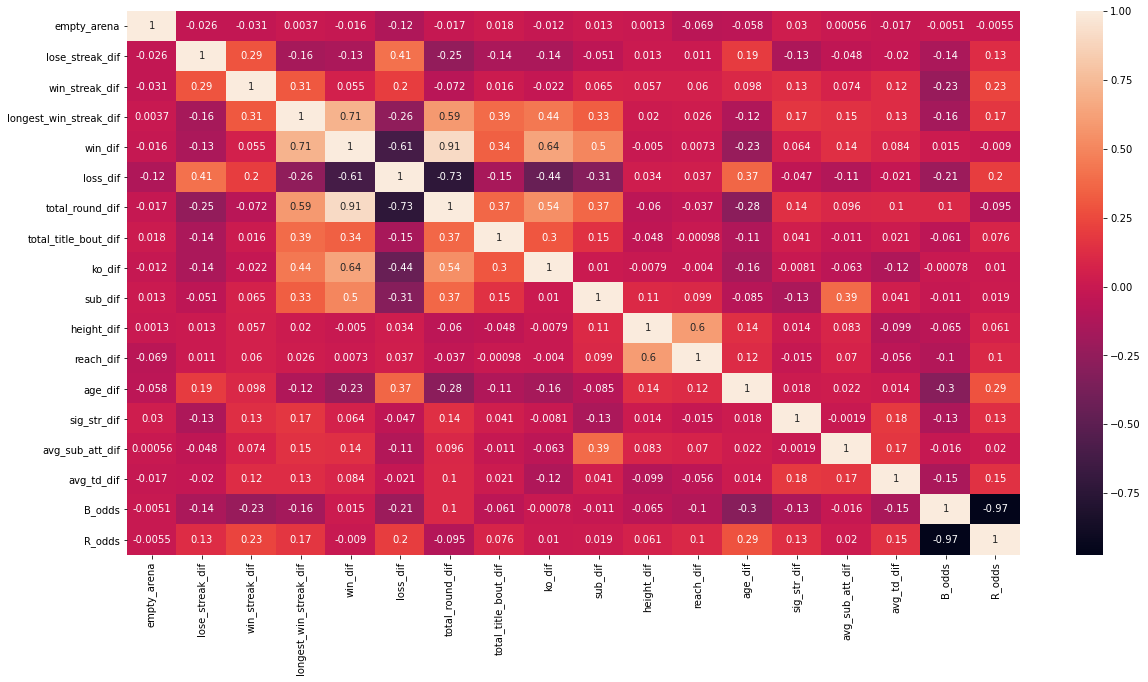

In [13]:
plt.figure(figsize=(20,10))
sns.heatmap(ufc.corr(), annot=True)

Notes on correlation heatmap:

* There may be a problem with some of these **so we'll run a VIF analysis once data is cleaned all the way**
* These correlations make sense such as experience leading to better performance

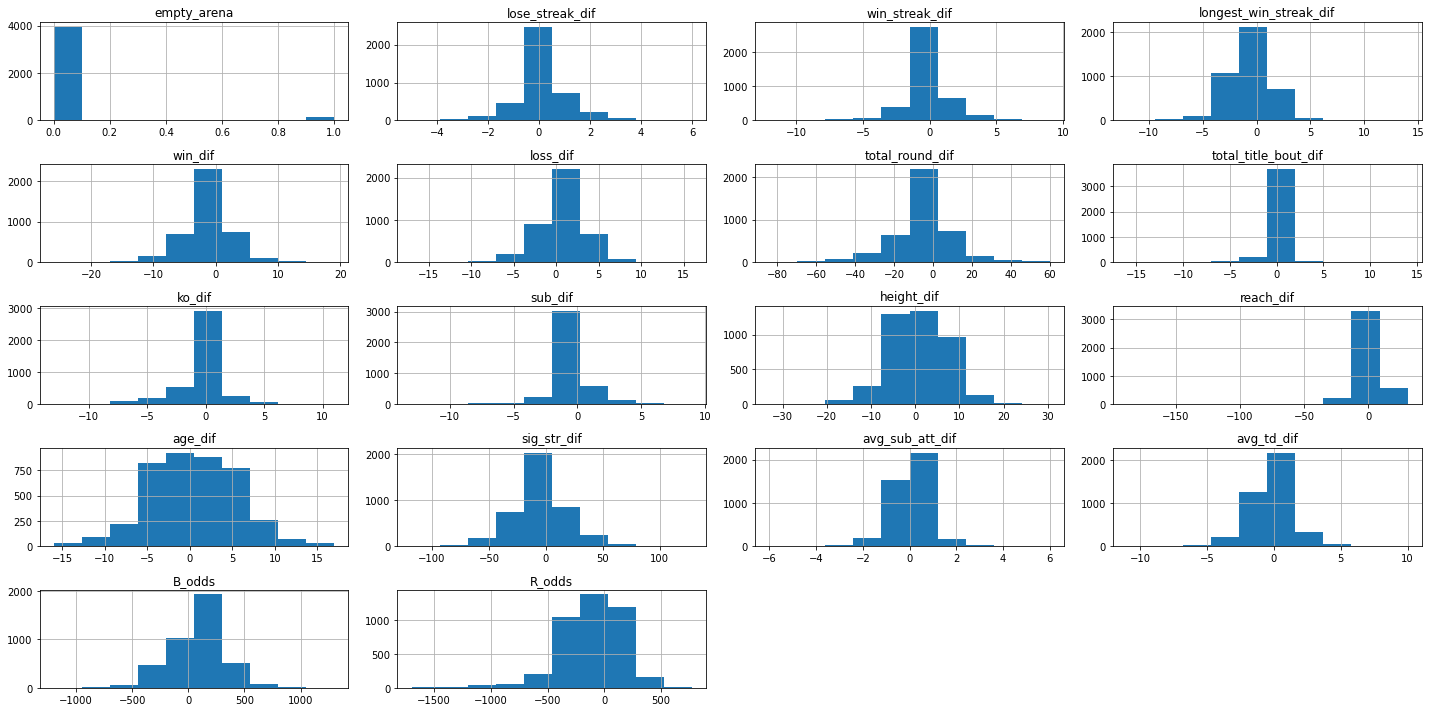

In [14]:
ufc.hist(figsize=(20,10))
plt.tight_layout()

Distribution notes:

* The differentials look nice and normal
* Need to bucket some of these, such as:
    * Empty arena
* Outliers to explore:
    * Odds for both corners
    * Reach differential

In [15]:
# check out odds and reach dif when more than three std devs away

# set cutoffs for stds
cuf_b = ufc['B_odds'].std() * 3
cuf_r = ufc['R_odds'].std() * 3
cuf_re = ufc['reach_dif'].std() * 3

# view outlier cases shape for each
print('blue fighter outlier rows:\t\t',ufc[abs(ufc['B_odds']) >= cuf_b].shape[0])
print('red fighter outlier rows:\t\t', ufc[abs(ufc['R_odds']) >= cuf_r].shape[0])
print('reach differential outlier rows:\t', ufc[abs(ufc['reach_dif']) >= cuf_re].shape[0])

blue fighter outlier rows:		 29
red fighter outlier rows:		 68
reach differential outlier rows:	 8


In [16]:
# remove reach outliers since that'll be used in both sets
ufc = ufc[abs(ufc['reach_dif']) < cuf_re]

Based on a conversation with my brother (a fellow UFC fan), we'll proceed by building a model without these outliers (to include reach advantage).  In addition, we'll build a model without the odds feature all together.

In [17]:
ufc['empty_arena'] = ufc['empty_arena'].astype('object') # converting arena status to object

<AxesSubplot:>

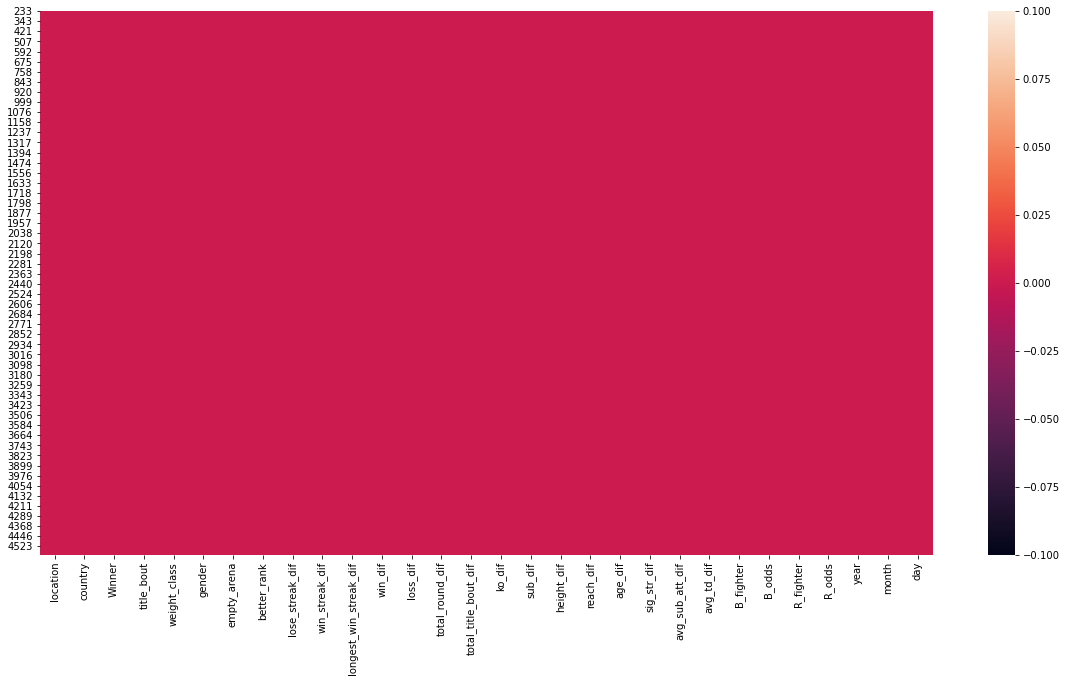

In [18]:
plt.figure(figsize=(20,10))
sns.heatmap(ufc.isna())

Missing value notes:

* No missing values!

In [19]:
for col in ufc.select_dtypes('object').columns:
    ufc[col] = ufc[col].apply(lambda x: str(x).strip()) # fixing whitespace issues

In [20]:
print('Categorical Counts:')
print()
for col in ufc.select_dtypes('object').columns:
    print(ufc.groupby(col)[col].count().sort_values(ascending=False))
    print()
    print('----------------------------------------------------------------------------------------------')
    print()

Categorical Counts:

location
Las Vegas, Nevada, USA               786
Newark, New Jersey, USA               77
Chicago, Illinois, USA                76
Toronto, Ontario, Canada              71
London, England, United Kingdom       70
                                    ... 
Beijing, China                         8
Saitama, Saitama, Japan                8
Gold Coast, Queensland, Australia      7
Manila, Philippines                    7
Shenzhen, Guangdong, China             6
Name: location, Length: 145, dtype: int64

----------------------------------------------------------------------------------------------

country
USA                     2484
Brazil                   380
Canada                   323
United Kingdom           155
Australia                152
United Arab Emirates      78
Sweden                    68
Mexico                    61
Germany                   52
Japan                     48
China                     42
Singapore                 37
Russia                  

Notes after categorical counts:

* Removing specific locations and only keeping countries
* **Create hierarchical ordering for weight classes** to remove dimensions
* Not using the fighter name in model

In [21]:
# list out weight classes
ufc['weight_class'].unique()

array(['Light Heavyweight', 'Welterweight', 'Flyweight', 'Featherweight',
       'Middleweight', 'Strawweight', 'Lightweight', 'Bantamweight',
       'Heavyweight', 'Catch Weight'], dtype=object)

In [22]:
# inspect catch weight
ufc[ufc['weight_class'] == 'Catch Weight'].shape

(19, 30)

There's only 19 catchweight fights, let's remove that.

In [23]:
# remove catchweight
ufc = ufc[ufc['weight_class'] != 'Catch Weight']

# make weight class ordinal
ufc['weight_class'] = ufc['weight_class'].astype('category')
ufc['weight_class']= ufc['weight_class'].cat.reorder_categories(['Strawweight', 'Flyweight', 'Bantamweight',
                                                                 'Featherweight', 'Lightweight', 'Welterweight',
                                                                 'Middleweight', 'Light Heavyweight', 'Heavyweight'],
                                                                ordered=True)



Now that the data is cleaned, we'll create two data sets, one without odds and one with odds but with removed outliers.

In [24]:
# reference for columns to drop
ufc.columns

Index(['location', 'country', 'Winner', 'title_bout', 'weight_class', 'gender',
       'empty_arena', 'better_rank', 'lose_streak_dif', 'win_streak_dif',
       'longest_win_streak_dif', 'win_dif', 'loss_dif', 'total_round_dif',
       'total_title_bout_dif', 'ko_dif', 'sub_dif', 'height_dif', 'reach_dif',
       'age_dif', 'sig_str_dif', 'avg_sub_att_dif', 'avg_td_dif', 'B_fighter',
       'B_odds', 'R_fighter', 'R_odds', 'year', 'month', 'day'],
      dtype='object')

In [25]:
# create no odds set
ufc_no = ufc.drop(['location', 'B_odds', 'R_odds', 'B_fighter', 'R_fighter'], axis=1)

# create outlier removed set
ufc_wo = ufc[(abs(ufc['B_odds']) < cuf_b) | (abs(ufc['R_odds']) < cuf_r)]
ufc_wo = ufc_wo.drop(['location', 'B_fighter', 'R_fighter'], axis=1)

In [27]:
# view shapes for sanity check
print(ufc_no.shape, ufc_wo.shape)

(4072, 25) (4049, 27)


With features selected, let's widdle down further by removing features with high VIF values to reduce multicollinearity issues for parametric models. We do this first with the no odds set followed by the odds set

In [31]:
# Without odds

from statsmodels.stats.outliers_influence import variance_inflation_factor

# the independent variables set
X = ufc_no.select_dtypes('number')
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                   feature        VIF
0          lose_streak_dif   1.532099
1           win_streak_dif   1.438831
2   longest_win_streak_dif   3.442341
3                  win_dif  22.993331
4                 loss_dif   3.662019
5          total_round_dif  16.258410
6     total_title_bout_dif   1.497784
7                   ko_dif   3.348109
8                  sub_dif   2.698932
9               height_dif   1.756449
10               reach_dif   1.726530
11                 age_dif   1.208500
12             sig_str_dif   1.232978
13         avg_sub_att_dif   1.248160
14              avg_td_dif   1.171409


For the no odds data, the results suggest we should remove win differentials and total_round differentials since their VIF values are well over 10.  Let's view the correlation matrix to understand this better.

<AxesSubplot:>

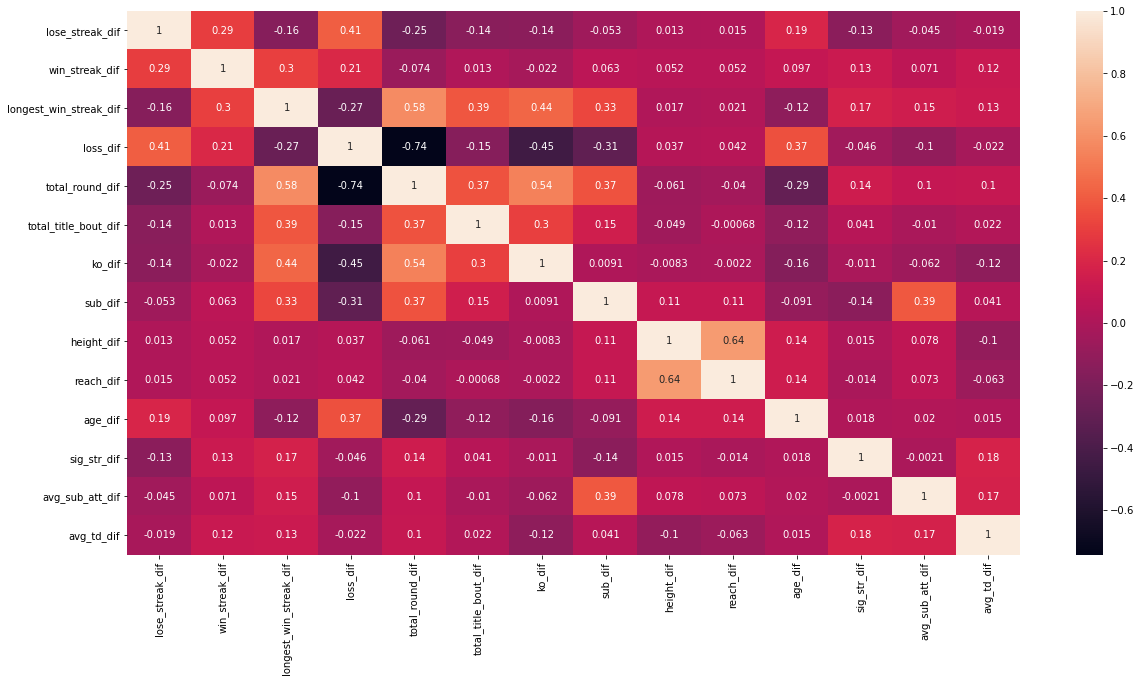

In [34]:
plt.figure(figsize=(20,10))
sns.heatmap(ufc_no.corr(), annot=True)

It seems as though both of our variables of interest are both negatively and positively correlated with many of our other features.  Let's try the same VIF analysis with the removed win differential since total rounds seems like a variable that would impact a fight's outcome.

In [32]:
# Without odds

# the independent variables set
X = ufc_no.select_dtypes('number').drop('win_dif', axis=1) # dropping win dif this time!
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                   feature       VIF
0          lose_streak_dif  1.462369
1           win_streak_dif  1.436160
2   longest_win_streak_dif  2.751253
3                 loss_dif  3.467145
4          total_round_dif  4.658720
5     total_title_bout_dif  1.357513
6                   ko_dif  1.936468
7                  sub_dif  1.707809
8               height_dif  1.755017
9                reach_dif  1.726514
10                 age_dif  1.208418
11             sig_str_dif  1.219076
12         avg_sub_att_dif  1.244714
13              avg_td_dif  1.161277


These results tell us that dropping win differentials reduces multicollinearity issues.  We'll drop it for the no odds model.

In [33]:
# dropping win dif
ufc_no.drop('win_dif', axis=1, inplace=True)

We'll run the same process on the odds data.

In [35]:
# With odds

# the independent variables set
X = ufc_wo.select_dtypes('number')
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                   feature        VIF
0          lose_streak_dif   1.539815
1           win_streak_dif   1.436001
2   longest_win_streak_dif   3.497046
3                  win_dif  22.955418
4                 loss_dif   3.652611
5          total_round_dif  16.296049
6     total_title_bout_dif   1.496259
7                   ko_dif   3.366819
8                  sub_dif   2.710229
9               height_dif   1.760646
10               reach_dif   1.737140
11                 age_dif   1.280037
12             sig_str_dif   1.254546
13         avg_sub_att_dif   1.248412
14              avg_td_dif   1.195381
15                  B_odds  15.471871
16                  R_odds  15.653279


Similar issue here so we'll view the heatmap to understand the results.

<AxesSubplot:>

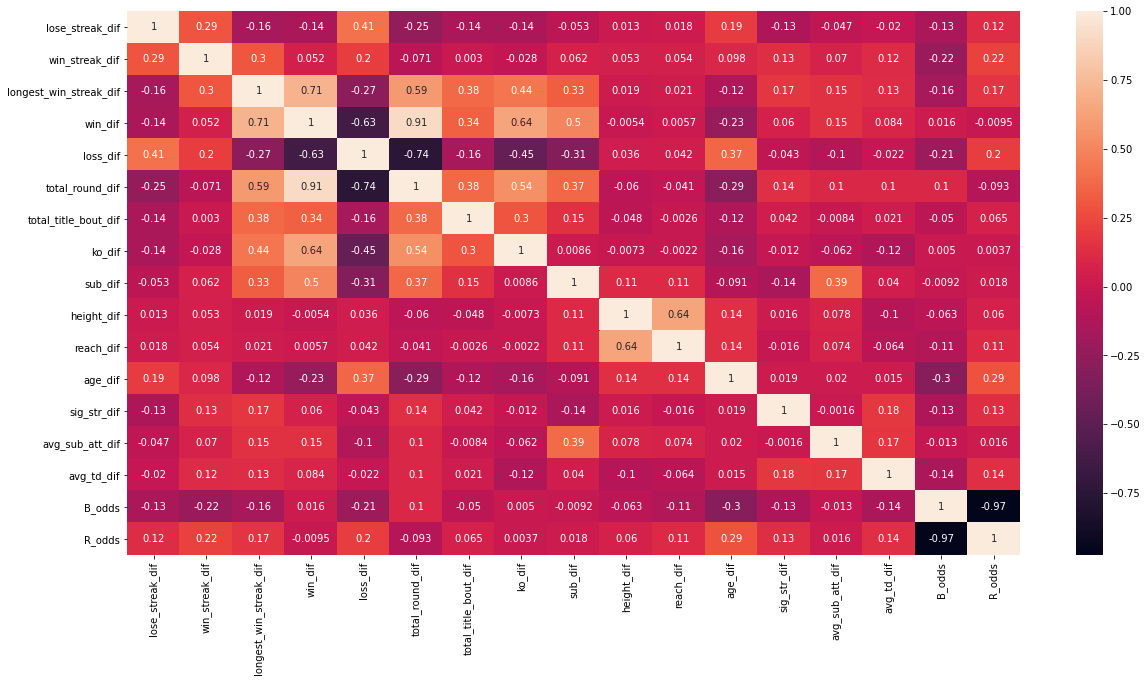

In [36]:
plt.figure(figsize=(20,10))
sns.heatmap(ufc_wo.corr(), annot=True)

As expected, odds are very negatively correlated with each other.  We're seeing a similar pattern with win differentials and total round experience so we'll drop win differentials like the no odds data and try removing one of the odds columns in the next VIF analysis.

In [38]:
# With odds

# the independent variables set
X = ufc_wo.select_dtypes('number').drop(['R_odds', 'win_dif'], axis=1) # dropping 1 odds and win dif!
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                   feature       VIF
0          lose_streak_dif  1.463767
1           win_streak_dif  1.428800
2   longest_win_streak_dif  2.810244
3                 loss_dif  3.457405
4          total_round_dif  4.703926
5     total_title_bout_dif  1.355448
6                   ko_dif  1.949354
7                  sub_dif  1.713804
8               height_dif  1.757058
9                reach_dif  1.735607
10                 age_dif  1.277704
11             sig_str_dif  1.237678
12         avg_sub_att_dif  1.244988
13              avg_td_dif  1.183085
14                  B_odds  1.271674


Removing win differentials and one of the odds columns reduces our multicollinearity issues.

In [39]:
ufc_wo.drop(['R_odds', 'win_dif'], axis=1, inplace=True)

The last step to take before modeling the data is to encode our categorical variables, except for weight class since we already created ordinal values for that.

In [111]:
def oh_encoder(df):
    '''
    One-hot encodes a UFC data set for modeling.
    '''
    
    # seperate target from data
    X = df.drop('Winner', axis=1)
    y = df['Winner']
    
    # get objects
    objs = X.select_dtypes('object')
    
    # list non-binary categories
    objs_mult = []
    
    # list binary cols
    objs_bi = []

    # check if object is binary
    for col in objs.columns:
        
        if len(df[col].unique()) > 2:
            objs_mult.append(col)
            
        else:
            objs_bi.append(col)    
     
    # create dfs for cases
    df_bi = objs[objs_bi]
    df_mult = pd.get_dummies(objs[objs_mult])
    df_num = X.drop(objs.columns, axis=1)
    
    # create final data frame
    df_out = pd.concat([df_bi, df_mult, df_num, y], axis=1)
    
    # encode binary and weight class
    df_out['weight_class'] = df_out['weight_class'].cat.codes
    df_out[objs_bi] = df_out[objs_bi].astype('category')
    
    # convert to 1 and 0 for binaries
    for col in objs_bi:
        df_out[col] = df_out[col].cat.codes
            
    # return encoded data
    return df_out

In [113]:
# save both encoded sets
no_odds = oh_encoder(ufc_no)
odds = oh_encoder(ufc_wo)

The data is ready to use for modeling.

-----

## Modeling

### No Odds

In [115]:
from sklearn.model_selection import train_test_split